## An architecture's energy and latency breakdown

In this demo, we dive deeper into the internal components of ZigZag's cost model by showing key aspects in the energy and latency calculation of a layer. 

First, we load in the ONNX model of AlexNet, which is the DNN used in this example.


In [3]:
# Load in the AlexNet ONNX model. (taken from onnx model zoo)
import onnx
onnx_model_path = "alexnet.onnx"
onnx_model = onnx.load(onnx_model_path, load_external_data=False)

Next, we run ZigZag through the API, extracting the layer-by-layer hardware performance on the Edge-TPU architecture. It returns the total network energy, latency and 'CostModelEvaluation'. A pickle file is saved containing the optimal 'CostModelEvaluation' of each individual layer in 'pickle_filename'.

In [4]:
from zigzag.api import get_hardware_performance
from zigzag.inputs.examples.mapping.alexnet_on_edge_tpu_like import mapping as mapping_edge_tpu
pickle_filename = "outputs/layer_cmes_alexnet.pickle"
energy, latency, network_cme = get_hardware_performance(onnx_model, "edge-tpu", mapping_edge_tpu, pickle_filename=pickle_filename)

2023-01-18 16:54:41,410 - generate_layer_node_for_conv +175 - INFO - Parsed convolutional node 
2023-01-18 16:54:41,412 - generate_layer_node_for_conv +175 - INFO - Parsed convolutional node 
2023-01-18 16:54:41,415 - generate_layer_node_for_conv +175 - INFO - Parsed convolutional node 
2023-01-18 16:54:41,418 - generate_layer_node_for_conv +175 - INFO - Parsed convolutional node 
2023-01-18 16:54:41,420 - generate_layer_node_for_conv +175 - INFO - Parsed convolutional node 
2023-01-18 16:54:41,420 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-01-18 16:54:41,421 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-01-18 16:54:41,422 - generate_layer_node_for_gemm +112 - INFO - Parsed Gemm node 
2023-01-18 16:54:41,422 - parse_workload_from_onnx_model_and_mapping +101 - INFO - Created ONNXWorkload graph with 24 nodes and 23 edges.
2023-01-18 16:54:41,427 - parse_accelerator_from_path +56 - INFO - Parsed accelerator with cores [1].
2023-01-18 16:54:41

We can print the total network energy and latency:

In [5]:
print(f"Total network energy= {energy:.2e}")
print(f"Total network latency= {latency:.2e}")

Total network energy= 5.66e+09
Total network latency= 8.26e+06


As logged during our ZigZag run, a list of 8 CMEs is saved to 'pickle_filename'. We load in this list and use the built-in visualization script to show an energy and latency breakdown for each of the layers. As the last fully connected layers are a clear bottleneck (you can verify this yourself by plotting all the CMEs instead of only the first 5), they are not plotted in this example.

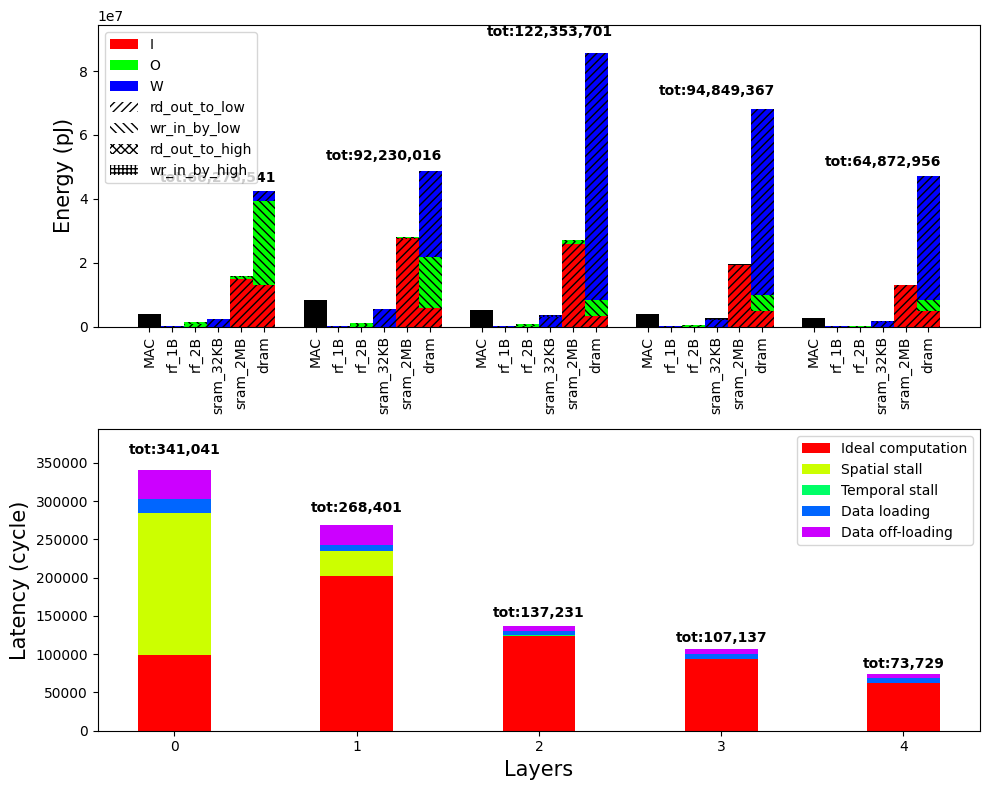

In [6]:
import pickle
from zigzag.visualization.results.plot_cme import bar_plot_cost_model_evaluations_breakdown

# Load in the pickled list of CMEs
with open(pickle_filename, 'rb') as fp:
    breakdown_cmes = pickle.load(fp)

# Plot all the layers and save to 'plot_all.png'
bar_plot_cost_model_evaluations_breakdown(breakdown_cmes[:5], save_path="plot_breakdown.png")


As mentioned, this plot shows the different layers of AlexNet. It has two core components: the top one showing the energy breakdown, and the bottom one latency breakdown. 

### Energy breakdown

Different layer shapes have different activation sizes (I/O) and parameter sizes (W), which cause a varying number of memory accesses, depending on the layout of the memory hierarchy for each of these operands and the achievable reuse for each operand within each memory.

### Latency breakdown

Different aspects impact the latency. The spatial under-utilization of the array leads to "spatial stalls", where as insufficient memory bandwidth can lead to "temporal stalls".